# [Convolutional Neural Networks with Intermediate Loss for 3D Super-Resolution of CT and MRI Scans](https://arxiv.org/abs/2001.01330)

This notebook is a replication/exploration of the paper linked above. Models were tested on the ABIDEII-BNI1 anatomical scans (subjects 29006 - 29011 for training, 29012 - 29015 for testing). This data can be found [here](http://fcon_1000.projects.nitrc.org/indi/abide/abide_II.html) in the Barrow Neurological Institute `Scan Data` link.

## Setup
There is an assumed organization of the MRI files from ABIDEII-BNI1 in this exercise with respect to this folder. If you have these files in the correct folder, you should receive the same (or similar) results. The files are not provided in this repository for file size reasons. If this is not the case for you, change the references to these files in `SrGen` in the following code to the correct locations.

```
../data/CNNIL_nifti/
                Raw_train/
                    subject_29006.nii
                    subject_29007.nii
                    subject_29008.nii
                    subject_29009.nii
                    subject_29010.nii
                    subject_29011.nii
                Raw_test/
                    subject_29012.nii
                    subject_29013.nii
                    subject_29014.nii
                    subject_29015.nii
```

### Imports
Like all good python scripts, we import a couple libraries. Note the importing of my own custom class `SrGen` for data loading/saving/organization. That is also in this repository, see the `/gen_utils/SrGen.py` for the source code.

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
import time
sys.path.append('..') # Stupid thing Python makes you do to import from a sibling directory
from gen_utils.SrGen import SrGen # Custom class for image generation

## Define model
Okay, the model described in the paper is actually quite easy to implement. They essentially are performing 3D SR through 2D SR across two different axes. In this case I label these axes `'hw'` and `'h' or 'w'`. You will see later how I use my custom `SrGen` class to convert a 3D MRI image into a collection of 2D images along different axes.
For instantiating this model, when `axs = 'hw'` you wish to have a model which takes a given 2D matrix (a slice of the MRI) and double the height and width. For `axs = 'h'` you wish to double the height (number of rows), and for `axs = 'w'` you wish to double the width (number of columns).

Note: This model only does 2x increase in resolution. If you wish to change the magnification you will have to change the number of output layers in `self.conv6` and `self.conv10`. You may also have to change the code in the `kern_upscale` method (haven't tested if it holds up).

In [40]:
class CNNIL(nn.Module):
    def __init__(self, upscale=2, axs = 'hw'):
        super().__init__()
        self.axs = axs

        self.rel = nn.ReLU()
        if axs == 'hw':
            self.conv1 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv2 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv3 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv4 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv5 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv6 = nn.Conv2d(32,4,3, padding='same', bias=False)
            
            # Upscale step occurs here

            self.conv7 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv8 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv9 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv10 = nn.Conv2d(32,1,3, padding='same', bias = False)
        elif axs == 'h' or axs == 'w':
            self.conv1 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv2 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv3 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv4 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv5 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv6 = nn.Conv2d(32,2,3, padding='same', bias=False)
            
            # Upscale step occurs here

            self.conv7 = nn.Conv2d(1,32,3, padding='same', bias=False)
            self.conv8 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv9 = nn.Conv2d(32,32,3, padding='same', bias=False)
            self.conv10 = nn.Conv2d(32,1,3, padding='same', bias = False)

    def forward(self, x):

        x = self.rel(self.conv1(x))
        
        x_l = self.rel(self.conv2(x))
        x_l = self.rel(self.conv3(x_l))
        x_l = self.rel(self.conv4(x_l+x))
        x_l = self.rel(self.conv5(x_l))
        x_l = self.rel(self.conv6(x_l+x))

        x_l = self.kern_upscale(x_l, axs = self.axs)

        x = self.rel(self.conv7(x_l))
        x_h = self.rel(self.conv8(x))
        x_h = self.rel(self.conv9(x_h))
        x_h = self.rel(self.conv10(x_h+x))

        return x_l, x_h #Return both results for the loss function

    @staticmethod
    def kern_upscale(x, axs='hw'):
        # Function to do the unique upscaling pattern they propose in
        # the paper
        s, c, h, w = [int(_) for _ in list(x.shape)]

        if axs == 'hw':
            c = int(c/2)

            b = torch.cat(torch.unbind(x,1),2)
            b = torch.reshape(b,(s,1,h*c,w*c))
            b = torch.transpose(b,2,3)
            b = torch.cat(torch.split(b,h,2),3)
            b = torch.reshape(b,(s,1,h*c,w*c))
            x_up = torch.transpose(b,2,3)

        elif axs == 'h':
            x_up = torch.unsqueeze(torch.cat(torch.unbind(x,2),1),1)
            #x_up = torch.unsqueeze(x_up,0)
        elif axs == 'w':
            x_up = torch.cat(torch.unbind(x,3),1)
            x_up = torch.unsqueeze(torch.transpose(x_up,1,2),1)
            #x_up = torch.unsqueeze(x_up,0)
        else:
            print('No valid scaling dimension selected, returning False')
            x_up = False

        return x_up


The below cell is for playing around with the methods described in the `kern_upscale` method, with an example 4D matrix in the same form the Pytorch uses.

In [41]:
# Testing of above kern_upscale function with 4D tensor (what the model will acually use)
a = torch.tensor([[[[1,2,0.1],[3,4,0.2],[0.3,0.4,0.5]],
                [[5,6,6.1],[7,8,6.2],[0.6,0.7,0.8]],
                [[9,10,6.3],[11,12,6.4],[0.9,1.1,1.2]],
                [[13,14,6.5],[15,16,6.6],[1.3,1.4,1.5]]]])
print(f'shape of a is {a.shape}')

b = torch.cat(torch.unbind(a,1),2)
b = torch.reshape(b,(1,1,6,6))
b = torch.transpose(b,2,3)
b = torch.cat(torch.split(b,3,2),3)
b = torch.reshape(b,(1,1,6,6))
b = torch.transpose(b,2,3)

# b = torch.transpose(b,2,3)
# b = torch.cat(torch.split(b,2,2),3)
# b = torch.transpose(torch.reshape(b,(1,1,6,6)),2,3)
b.shape

shape of a is torch.Size([1, 4, 3, 3])


torch.Size([1, 1, 6, 6])

## Set Optimization Parameters
Now that we have the model defined, we can instantiate it as the first block (`net_1`) and second block (`net_2`) of the CNN pipeline. I also define `intermediate_loss`, which is the loss function they discuss in the paper. They use the resulting images after the upscaling step and the final output to calculate loss in comparison to the "true" high resolution image.

In [42]:
net_1 = CNNIL(axs = 'hw')
net_2 = CNNIL(axs = 'w')

# "... trained the CNN for 40 epochs, starting with a learning rate of 0.001 and decreasing
# the learning rate to 0.0001 after the first 20 epochs"
optimizer_1 = optim.Adam(net_1.parameters(), lr=0.001)
optimizer_2 = optim.Adam(net_2.parameters(), lr=0.001)

# They have a custom loss function that incorporates the final results and the result
# right after the upscaling step
# https://discuss.pytorch.org/t/custom-loss-functions/29387

def intermediate_loss(output_intermediate, output_final, target):
    mae_loss = nn.L1Loss() #Built in mean absolute error loss function
    loss = mae_loss(output_intermediate, target)+mae_loss(output_final, target)
    return loss


## Generate Data for Training
This is where I get to show off my custom class for creating the 2D image patches used in training the first CNN block. In this implimentation I load all of the files in the `../data/CNNIL_nifti/Raw_train/` and scale a copy of each image down by a magintude of 2 along the first two axes using bilinear interpolation. From the original images (HR) samples of size `[14,14,1]` from each 3D image using step sizes of `[12,12,4]` are collected and saved as individual `.nii` files in `../data/CNNIL_nifti/HR_train_1/`. From the scaled down (or LR) images, patches of size `[7,7,1]` are take with step size `[6,6,4]` are collected and saved in `../data/CNNIL_nifti/LR_train_1/`. The LR and HR patches of the same relative locations are named the same things, so they can be loaded together during training of the model. You can also apply randomized translation (voxels) and rotation (degrees) along the different axes.

WARNING: This will make a lot of files, as each patch is saved as a seperate `.nii` file. You should expect >2,000 files per MRI image. This is done to reduce overhead and RAM usage on personal computers.

In [43]:
sr_train_1 = SrGen('../data/CNNIL_nifti/Raw_train/','../data/CNNIL_nifti/HR_train_1/','../data/CNNIL_nifti/LR_train_1/')

temp = sr_train_1.get_template() #Get the default template in order to tweak parameters
temp['out_type'] = 'nii' #what format to save the resulting HR and LR files as
temp['resolution'] = [2,2,1] #What magnitude to scale down each dimension of the image
temp['translation'] = [0, 0, 0] #Range of voxels translation to be randomly selected along each axes. Ex. [2,3,0] will apply a random translation of -2 <= x <= 2 along the first dimension,
                                # -3 < x < 3 along the second dimension, and 0 along the third dimension of each processed input image.
temp['rotation'] = [0, 0, 0] #Range of degrees to random select rotation along each axes. Same idea as 'translation' setting, but with rotation being in degrees around each axes.
temp['keep_blank'] = False, #Whether to keep patches which have >template['keep_blank'] ratio of non-zero values
temp['same_size'] = False #Whether, after being scaled down, the LR image is scaled back up to its original size by the same method
temp['patch'] = [14,14,1] #Size along each dimension of each patch. For reference: [x,y,z] when looking at the brain from the top down
temp['step'] = [12,12,4] #Step size between patches taken
sr_train_1.set_template(temp) #Pass the changed template back into the class


# Run the commented line below to generate new patches/folders. If the files already exist in the specified directories, then run the `match_altered` command instead.
# sr_train_1.run(clear=True, save=True)

# Run command line below when patches already exist, in order to prevent pointless rerunning of data
sr_train_1.match_altered(update=True, paths=False, sort=False)

HR and LR file locations updated


Now do the same with the second CNN block, this time only scaling the remaining axes down by 2

In [44]:
sr_train_2 = SrGen('../data/CNNIL_nifti/Raw_train/','../data/CNNIL_nifti/HR_train_2/','../data/CNNIL_nifti/LR_train_2/')
temp = sr_train_2.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [1,1,2]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [1,7,14] #[x,y,z] when looking at the brain from the top down
temp['step'] = [4,6,12]
sr_train_2.set_template(temp)

# sr_train_2.run(clear=True, save=True)
sr_train_2.match_altered(update=True, paths=False, sort=False)

HR and LR file locations updated


# Create Dataloader
Now we create a Pytorch `Dataset`. Once again, my custom class makes this easier with the `load_image_pair` method, which will output the matched HR and LR patches as numpy arrays.

In [45]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sr_class, axs='hw'):
        self.sr_class = sr_class
        self.axs = axs

        # In case I forget to run match_altered before pulling the class
        if not sr_class.HR_files:
            sr_class.match_altered(update=True)

    def __len__(self):
        return len(self.sr_class.HR_files)

    def __getitem__(self, index):
        Y, X = self.sr_class.load_image_pair(index)

        # SR along two axes
        if self.axs == 'hw':
            X = torch.unsqueeze(torch.squeeze(torch.tensor(X, dtype=torch.float32),-1),0)
            Y = torch.unsqueeze(torch.squeeze(torch.tensor(Y, dtype=torch.float32),-1),0)

        # SR along one axis
        elif self.axs == 'h':
            X = torch.tensor(X, dtype=torch.float32)
            Y = torch.tensor(Y, dtype=torch.float32)
        elif self.axs == 'w':
            X = torch.tensor(X, dtype=torch.float32)
            Y = torch.tensor(Y, dtype=torch.float32)
        else:
            raise NotImplementedError(f'Super resolution along {self.axs} currently not supported')
            
        return X,Y

## Create Dataloader for Training

In [46]:
params = {'batch_size': 128,
        'shuffle': True,
        'num_workers': 2}

training_set_1 = Dataset(sr_train_1, axs = 'hw')
training_generator_1 = torch.utils.data.DataLoader(training_set_1, **params)


training_set_2 = Dataset(sr_train_2, axs = 'w')
training_generator_2 = torch.utils.data.DataLoader(training_set_2, **params)

# Training Loop

In [47]:
max_epochs = 40
save_rate = 10 #How often to save the model weights (in case your computer runs out of RAM or something interupts the training process)
save_prefix = "./CNNIL_save" #Where you want to save the model weights

# Store loss values
mean_loss = {'CNNIL_1': [],
            'CNNIL_2':[]}

for epoch in tqdm(range(max_epochs)):
    losses = []

    # Training
    count = 0
    for inp, goal in training_generator_1:
        optimizer_1.zero_grad()

        output_1, output_2 = net_1(inp)

        loss = intermediate_loss(output_1,output_2,goal)
        loss.backward()
        optimizer_1.step()
        losses.append(loss.item())
        count = count+1
    

    if (epoch % save_rate == 0) or epoch == (max_epochs-1):
        torch.save(net_1.state_dict(), f'{save_prefix}_network1_{epoch}.p')
    print(f'CNNIL_1 : epoch {epoch}, loss mean: {sum(losses)/len(losses)}, loss: {min(losses)}-{max(losses)}')
    mean_loss["CNNIL_1"].append(sum(losses)/len(losses))

    # Give computer time to cool down
    time.sleep(10)


for epoch in tqdm(range(max_epochs)):
    losses = []

    # Training
    count = 0
    for inp, goal in training_generator_2:
        optimizer_2.zero_grad()

        output_1, output_2 = net_2(inp)

        loss = intermediate_loss(output_1,output_2,goal)
        loss.backward()
        optimizer_2.step()
        losses.append(loss.item())
        count = count+1
    

    if (epoch % save_rate == 0) or epoch == (max_epochs-1):
        torch.save(net_2.state_dict(), f'{save_prefix}_network2_{epoch}.p')
    print(f'CNNIL_2 : epoch {epoch}, loss mean: {sum(losses)/len(losses)}, loss: {min(losses)}-{max(losses)}')
    mean_loss["CNNIL_2"].append(sum(losses)/len(losses))

    # Give computer time to cool down
    time.sleep(10)


  0%|          | 0/40 [00:00<?, ?it/s]

CNNIL_1 : epoch 0, loss mean: 32.42629266396547, loss: 20.510427474975586-116.09200286865234


  2%|▎         | 1/40 [00:29<18:55, 29.13s/it]

CNNIL_1 : epoch 1, loss mean: 22.08823409447303, loss: 18.944128036499023-24.752777099609375


  5%|▌         | 2/40 [00:59<18:52, 29.81s/it]

CNNIL_1 : epoch 2, loss mean: 21.522326942183014, loss: 19.380491256713867-23.652721405029297


  8%|▊         | 3/40 [01:29<18:34, 30.12s/it]

CNNIL_1 : epoch 3, loss mean: 21.336197152097, loss: 19.324630737304688-23.721221923828125


 10%|█         | 4/40 [01:59<17:59, 29.98s/it]

CNNIL_1 : epoch 4, loss mean: 21.129527621799046, loss: 19.522624969482422-22.99131965637207


 12%|█▎        | 5/40 [02:29<17:23, 29.81s/it]

CNNIL_1 : epoch 5, loss mean: 21.08857185820229, loss: 18.997209548950195-22.95809555053711


 15%|█▌        | 6/40 [03:00<17:10, 30.32s/it]

CNNIL_1 : epoch 6, loss mean: 21.00392094636575, loss: 19.15585708618164-23.113224029541016


 18%|█▊        | 7/40 [03:30<16:36, 30.21s/it]

CNNIL_1 : epoch 7, loss mean: 21.02322489583594, loss: 18.781932830810547-23.04938507080078


 20%|██        | 8/40 [04:01<16:14, 30.45s/it]

CNNIL_1 : epoch 8, loss mean: 20.94636709262163, loss: 18.929264068603516-23.202268600463867


 22%|██▎       | 9/40 [04:32<15:52, 30.73s/it]

CNNIL_1 : epoch 9, loss mean: 20.882266444018764, loss: 19.019004821777344-22.647184371948242


 25%|██▌       | 10/40 [05:03<15:19, 30.64s/it]

CNNIL_1 : epoch 10, loss mean: 21.124363279750206, loss: 19.076946258544922-23.601438522338867


 28%|██▊       | 11/40 [05:33<14:49, 30.68s/it]

CNNIL_1 : epoch 11, loss mean: 20.782297191456852, loss: 18.84222984313965-22.678512573242188


 30%|███       | 12/40 [06:04<14:16, 30.61s/it]

CNNIL_1 : epoch 12, loss mean: 20.752559449937607, loss: 19.28343391418457-22.513193130493164


 32%|███▎      | 13/40 [06:35<13:48, 30.69s/it]

CNNIL_1 : epoch 13, loss mean: 20.73335931239984, loss: 18.994762420654297-22.33751678466797


 35%|███▌      | 14/40 [07:05<13:16, 30.65s/it]

CNNIL_1 : epoch 14, loss mean: 20.744318896888668, loss: 18.603757858276367-22.726232528686523


 38%|███▊      | 15/40 [07:36<12:48, 30.75s/it]

CNNIL_1 : epoch 15, loss mean: 20.702923733963924, loss: 18.269989013671875-22.472352981567383


 40%|████      | 16/40 [08:08<12:20, 30.87s/it]

CNNIL_1 : epoch 16, loss mean: 20.680825608408348, loss: 18.49915313720703-22.6426944732666


 42%|████▎     | 17/40 [08:39<11:53, 31.02s/it]

CNNIL_1 : epoch 17, loss mean: 20.652787966605946, loss: 19.01215362548828-23.230907440185547


 45%|████▌     | 18/40 [09:09<11:18, 30.82s/it]

CNNIL_1 : epoch 18, loss mean: 20.618190806136173, loss: 18.453664779663086-22.11587142944336


 48%|████▊     | 19/40 [09:40<10:47, 30.83s/it]

CNNIL_1 : epoch 19, loss mean: 20.598100303584694, loss: 18.41936683654785-22.351743698120117


 50%|█████     | 20/40 [10:11<10:18, 30.92s/it]

CNNIL_1 : epoch 20, loss mean: 20.586923371013413, loss: 18.30691909790039-22.381488800048828


 52%|█████▎    | 21/40 [10:43<09:51, 31.12s/it]

CNNIL_1 : epoch 21, loss mean: 20.55005719926622, loss: 18.705142974853516-23.0019474029541


 55%|█████▌    | 22/40 [11:14<09:19, 31.07s/it]

CNNIL_1 : epoch 22, loss mean: 20.518387876005253, loss: 18.345478057861328-22.442541122436523


 57%|█████▊    | 23/40 [11:44<08:44, 30.87s/it]

CNNIL_1 : epoch 23, loss mean: 20.538445146674785, loss: 18.554502487182617-23.359207153320312


 60%|██████    | 24/40 [12:16<08:16, 31.03s/it]

CNNIL_1 : epoch 24, loss mean: 20.50107875237098, loss: 18.424861907958984-22.330385208129883


 62%|██████▎   | 25/40 [12:47<07:45, 31.02s/it]

CNNIL_1 : epoch 25, loss mean: 20.496042357550728, loss: 18.845840454101562-22.789379119873047


 65%|██████▌   | 26/40 [13:17<07:13, 30.97s/it]

CNNIL_1 : epoch 26, loss mean: 20.477977035392044, loss: 18.46038818359375-22.147790908813477


 68%|██████▊   | 27/40 [13:48<06:41, 30.91s/it]

CNNIL_1 : epoch 27, loss mean: 20.454397389012524, loss: 18.826208114624023-22.538049697875977


 70%|███████   | 28/40 [14:20<06:13, 31.09s/it]

CNNIL_1 : epoch 28, loss mean: 20.473509796664246, loss: 18.442975997924805-22.801353454589844


 72%|███████▎  | 29/40 [14:51<05:42, 31.17s/it]

CNNIL_1 : epoch 29, loss mean: 20.42919413248698, loss: 18.50565528869629-22.950969696044922


 75%|███████▌  | 30/40 [15:22<05:09, 30.99s/it]

CNNIL_1 : epoch 30, loss mean: 20.449252356830826, loss: 18.441572189331055-22.398868560791016


 78%|███████▊  | 31/40 [15:53<04:38, 30.99s/it]

CNNIL_1 : epoch 31, loss mean: 20.403526599590595, loss: 18.034263610839844-22.31856346130371


 80%|████████  | 32/40 [16:24<04:09, 31.21s/it]

CNNIL_1 : epoch 32, loss mean: 20.391304725255722, loss: 18.55729103088379-22.14704704284668


 82%|████████▎ | 33/40 [16:55<03:37, 31.01s/it]

CNNIL_1 : epoch 33, loss mean: 20.41669080196283, loss: 18.205318450927734-22.83870506286621


 85%|████████▌ | 34/40 [17:26<03:06, 31.12s/it]

CNNIL_1 : epoch 34, loss mean: 20.374195261898205, loss: 18.582351684570312-22.2811279296875


 88%|████████▊ | 35/40 [17:57<02:35, 31.11s/it]

CNNIL_1 : epoch 35, loss mean: 20.396509235740726, loss: 18.146268844604492-22.025407791137695


 90%|█████████ | 36/40 [18:28<02:04, 31.09s/it]

CNNIL_1 : epoch 36, loss mean: 20.372599088228664, loss: 17.97907829284668-22.308752059936523


 92%|█████████▎| 37/40 [19:00<01:33, 31.25s/it]

CNNIL_1 : epoch 37, loss mean: 20.363726950099327, loss: 18.83840560913086-21.970598220825195


 95%|█████████▌| 38/40 [19:31<01:02, 31.15s/it]

CNNIL_1 : epoch 38, loss mean: 20.355808298811954, loss: 18.29077911376953-22.70865821838379


 98%|█████████▊| 39/40 [20:02<00:31, 31.03s/it]

CNNIL_1 : epoch 39, loss mean: 20.3541963120811, loss: 18.623058319091797-22.430906295776367


  0%|          | 0/40 [00:00<?, ?it/s]

CNNIL_2 : epoch 0, loss mean: 11.956213313983813, loss: 5.016570091247559-118.86410522460938


  2%|▎         | 1/40 [00:56<36:34, 56.28s/it]

CNNIL_2 : epoch 1, loss mean: 5.699861318818106, loss: 4.702746391296387-8.602746963500977


  5%|▌         | 2/40 [01:50<34:53, 55.08s/it]

CNNIL_2 : epoch 2, loss mean: 5.383472497065022, loss: 4.249868392944336-6.3718366622924805


  8%|▊         | 3/40 [02:45<33:52, 54.92s/it]

CNNIL_2 : epoch 3, loss mean: 5.304310942805091, loss: 4.231544494628906-7.789777755737305


 10%|█         | 4/40 [03:38<32:33, 54.27s/it]

CNNIL_2 : epoch 4, loss mean: 5.095137840093568, loss: 4.2370123863220215-5.983239650726318


 12%|█▎        | 5/40 [04:31<31:23, 53.80s/it]

CNNIL_2 : epoch 5, loss mean: 5.052207165490246, loss: 4.3863606452941895-6.277651786804199


 15%|█▌        | 6/40 [05:24<30:17, 53.44s/it]

CNNIL_2 : epoch 6, loss mean: 4.952985950050596, loss: 3.8357882499694824-5.97877311706543


 18%|█▊        | 7/40 [06:14<28:44, 52.25s/it]

CNNIL_2 : epoch 7, loss mean: 4.938456614980234, loss: 4.325093746185303-5.621645927429199


 20%|██        | 8/40 [07:05<27:46, 52.09s/it]

CNNIL_2 : epoch 8, loss mean: 4.89133507605587, loss: 4.110595703125-5.760623931884766


 22%|██▎       | 9/40 [07:56<26:40, 51.64s/it]

CNNIL_2 : epoch 9, loss mean: 4.8825617693443375, loss: 4.057065010070801-5.741398811340332


 25%|██▌       | 10/40 [08:46<25:37, 51.25s/it]

CNNIL_2 : epoch 10, loss mean: 4.836682416419902, loss: 4.091468811035156-5.547138214111328


 28%|██▊       | 11/40 [09:38<24:50, 51.39s/it]

CNNIL_2 : epoch 11, loss mean: 4.81215904227775, loss: 4.032651901245117-5.687994956970215


 30%|███       | 12/40 [10:30<24:02, 51.51s/it]

CNNIL_2 : epoch 12, loss mean: 4.823900793369931, loss: 4.06928825378418-6.814850807189941


 32%|███▎      | 13/40 [11:20<23:00, 51.13s/it]

CNNIL_2 : epoch 13, loss mean: 4.765976574153779, loss: 4.004851341247559-5.554683685302734


 35%|███▌      | 14/40 [12:11<22:11, 51.21s/it]

CNNIL_2 : epoch 14, loss mean: 4.756747726658182, loss: 4.110367774963379-5.525012969970703


 38%|███▊      | 15/40 [13:02<21:14, 51.00s/it]

CNNIL_2 : epoch 15, loss mean: 4.736506960104686, loss: 3.746397018432617-5.495760917663574


 40%|████      | 16/40 [13:53<20:25, 51.05s/it]

CNNIL_2 : epoch 16, loss mean: 4.7333729110862945, loss: 4.006560325622559-5.881702423095703


 42%|████▎     | 17/40 [14:43<19:28, 50.81s/it]

CNNIL_2 : epoch 17, loss mean: 4.700200109098729, loss: 3.986142635345459-5.622200012207031


 45%|████▌     | 18/40 [15:35<18:45, 51.14s/it]

CNNIL_2 : epoch 18, loss mean: 4.704180375214107, loss: 3.926933526992798-5.424560546875


 48%|████▊     | 19/40 [16:25<17:43, 50.66s/it]

CNNIL_2 : epoch 19, loss mean: 4.692574290342109, loss: 4.1047515869140625-5.54669189453125


 50%|█████     | 20/40 [17:17<17:03, 51.19s/it]

CNNIL_2 : epoch 20, loss mean: 4.666231320725939, loss: 3.787747859954834-5.278238296508789


 52%|█████▎    | 21/40 [18:08<16:08, 50.97s/it]

CNNIL_2 : epoch 21, loss mean: 4.664186021994334, loss: 4.02866268157959-5.459961891174316


 55%|█████▌    | 22/40 [18:58<15:15, 50.84s/it]

CNNIL_2 : epoch 22, loss mean: 4.702468857956739, loss: 3.881432056427002-6.494865417480469


 57%|█████▊    | 23/40 [19:50<14:30, 51.19s/it]

CNNIL_2 : epoch 23, loss mean: 4.625366499257642, loss: 3.8931760787963867-5.398829460144043


 60%|██████    | 24/40 [20:40<13:29, 50.61s/it]

CNNIL_2 : epoch 24, loss mean: 4.634857920209146, loss: 3.8203511238098145-5.588902473449707


 62%|██████▎   | 25/40 [21:29<12:33, 50.24s/it]

CNNIL_2 : epoch 25, loss mean: 4.619888413532088, loss: 3.8157296180725098-5.271595001220703


 65%|██████▌   | 26/40 [22:18<11:40, 50.04s/it]

CNNIL_2 : epoch 26, loss mean: 4.6185127685740435, loss: 3.7189769744873047-5.378326416015625


 68%|██████▊   | 27/40 [23:08<10:50, 50.00s/it]

CNNIL_2 : epoch 27, loss mean: 4.60192167985767, loss: 3.890613317489624-5.636850357055664


 70%|███████   | 28/40 [23:58<09:59, 49.95s/it]

CNNIL_2 : epoch 28, loss mean: 4.61536959815479, loss: 4.031416893005371-5.36199426651001


 72%|███████▎  | 29/40 [24:49<09:12, 50.23s/it]

CNNIL_2 : epoch 29, loss mean: 4.588112024625815, loss: 3.8772315979003906-5.414231777191162


 75%|███████▌  | 30/40 [25:38<08:17, 49.78s/it]

CNNIL_2 : epoch 30, loss mean: 4.592652548191159, loss: 3.7963008880615234-5.584492206573486


 78%|███████▊  | 31/40 [26:27<07:25, 49.46s/it]

CNNIL_2 : epoch 31, loss mean: 4.580143932056226, loss: 3.920642614364624-5.20667839050293


 80%|████████  | 32/40 [27:16<06:34, 49.33s/it]

CNNIL_2 : epoch 32, loss mean: 4.577324937816402, loss: 3.6038126945495605-5.339774131774902


 82%|████████▎ | 33/40 [28:06<05:47, 49.70s/it]

CNNIL_2 : epoch 33, loss mean: 4.563236216914074, loss: 3.9094347953796387-5.399979591369629


 85%|████████▌ | 34/40 [28:57<04:59, 49.99s/it]

CNNIL_2 : epoch 34, loss mean: 4.565314667925522, loss: 3.737732410430908-5.361367702484131


 88%|████████▊ | 35/40 [29:46<04:09, 49.83s/it]

CNNIL_2 : epoch 35, loss mean: 4.557542683962284, loss: 3.6684207916259766-5.446324348449707


 90%|█████████ | 36/40 [30:37<03:21, 50.26s/it]

CNNIL_2 : epoch 36, loss mean: 4.55537371554788, loss: 3.7579405307769775-5.305699348449707


 92%|█████████▎| 37/40 [31:28<02:31, 50.33s/it]

CNNIL_2 : epoch 37, loss mean: 4.543184033407973, loss: 3.78543758392334-5.402949333190918


 95%|█████████▌| 38/40 [32:20<01:41, 50.73s/it]

CNNIL_2 : epoch 38, loss mean: 4.534762490879405, loss: 3.76162052154541-5.475910186767578


 98%|█████████▊| 39/40 [33:10<00:50, 50.61s/it]

CNNIL_2 : epoch 39, loss mean: 4.557323035427682, loss: 3.878964900970459-5.732965469360352


100%|██████████| 40/40 [34:02<00:00, 51.05s/it]


### Sanity Check
Let's plot the mean loss values for each epoch to make sure that they are going down

Text(0.5, 1.0, 'Mean Loss for Second CNN Block')

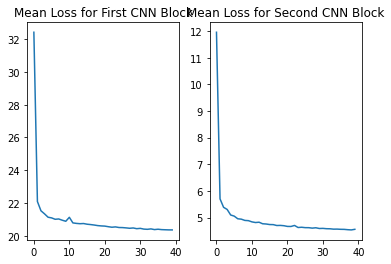

In [48]:
fig, axs = plt.subplots(1, 2)
axs[0].plot([x for x in range(len(mean_loss["CNNIL_1"]))],mean_loss["CNNIL_1"])
axs[0].set_title('Mean Loss for First CNN Block')
axs[1].plot([x for x in range(len(mean_loss["CNNIL_2"]))],mean_loss["CNNIL_2"])
axs[1].set_title('Mean Loss for Second CNN Block')

## Testing Model
Now let's do the same thing as training but with the data in our testing folder that we set aside to not be used in training.

In [49]:
# Generate testing data for both axes
sr_test_1 = SrGen('../data/CNNIL_nifti/Raw_test/','../data/CNNIL_nifti/HR_test_1/','../data/CNNIL_nifti/LR_test_1/')

temp = sr_test_1.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [2,2,1]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [14,14,1] #[x,y,z] when looking at the brain from the top down
temp['step'] = [12,12,4]
sr_test_1.set_template(temp)

#sr_test_1.run(clear=True, save=True)
sr_test_1.match_altered(update=True, paths=False, sort=False)


sr_test_2 = SrGen('../data/CNNIL_nifti/Raw_test/','../data/CNNIL_nifti/HR_test_2/','../data/CNNIL_nifti/LR_test_2/')
temp = sr_test_2.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [1,1,2]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
temp['keep_blank'] = False
temp['same_size'] = False
temp['patch'] = [1,7,14] #[x,y,z] when looking at the brain from the top down
temp['step'] = [4,6,12]
sr_test_2.set_template(temp)

#sr_test_2.run(clear=True, save=True)
sr_test_2.match_altered(update=True, paths=False, sort=False)


HR and LR file locations updated
HR and LR file locations updated


In [50]:
params_t = {'batch_size': 1,
        'shuffle': False,
        'num_workers': 2}

testing_set_1 = Dataset(sr_test_1, axs = 'hw')
testing_generator_1 = torch.utils.data.DataLoader(testing_set_1, **params_t)


testing_set_2 = Dataset(sr_test_2, axs = 'w')
testing_generator_2 = torch.utils.data.DataLoader(testing_set_2, **params_t)

#### Run both datasets through the model
Now that we have a model trained, let's test it! First lets look at the first CNN block and compare it to simple bilinear interpolation. We do this through calculation of the Peak Signal to Noise Ratio (PSNR) of both methods compared to the "true" HR image. We then look at the difference between the PSNR for both method by finding their difference.

In [51]:
# Load trained models:
net_1.load_state_dict(torch.load('CNNIL_save_network1_39.p'))


with torch.no_grad():
    comp={'psnr' : [], 'rmse' : []}
    for idx, [im_l, im_h] in enumerate(testing_generator_1):

        # Use SR model on low resolution image
        output_1, output_2 = net_1(im_l)

        # Upscale im_l to the same size as im_h
        im_l = torch.tensor(resize(im_l, im_h.shape, order=1, mode = 'symmetric'))

        # Calculate PSNR for bicubic
        diff = im_l - im_h
        rmse_b = np.sqrt((diff**2).mean())
        psnr_b = 20*np.log10(im_h.max()/rmse_b)

        #print(f'bicubic evaluation for {idx}: rms={rmse_b}, psnr={psnr_b}')

        # Calculate PSNR for SR
        diff = output_2 - im_h
        rmse_s = np.sqrt((diff**2).mean())
        psnr_s = 20*np.log10(im_h.max()/rmse_s)
        #print(f'SR evaluation for {idx}: rms={rmse_s}, psnr={psnr_s}')
        if idx % 50 == 0:
            comp['psnr'].append(psnr_s-psnr_b)
            comp['rmse'].append(rmse_s-rmse_b)


Text(0.5, 1.0, 'RMSE: SR - BiC')

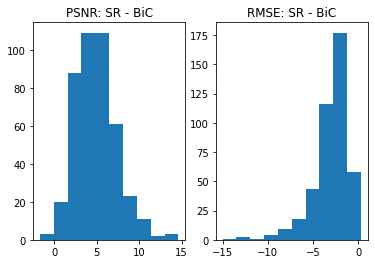

In [52]:
# Sanity check, plot a histogram of how well the SR image performed compared to the Bicubic comparison
fig, axs = plt.subplots(1, 2)
axs[0].hist([float(x) for x in comp['psnr']], bins=10)
axs[0].set_title('PSNR: SR - BiC')
axs[1].hist([float(x) for x in comp['rmse']], bins=10)
axs[1].set_title('RMSE: SR - BiC')

Awesome, a positive result in the first histogram and a negative in the second is what we want! Now we do the same with the second CNN block:

In [53]:
# Load trained models:
net_2.load_state_dict(torch.load('CNNIL_save_network2_39.p'))


with torch.no_grad():
    comp={'psnr' : [], 'rmse' : []}
    for idx, [im_l, im_h] in enumerate(testing_generator_2):

        # Use SR model on low resolution image
        output_1, output_2 = net_2(im_l)

        # Upscale im_l to the same size as im_h
        im_l = torch.tensor(resize(im_l, im_h.shape, order=1, mode = 'symmetric'))

        # Calculate PSNR for bicubic
        diff = im_l - im_h
        rmse_b = np.sqrt((diff**2).mean())
        psnr_b = 20*np.log10(im_h.max()/rmse_b)

        #print(f'bicubic evaluation for {idx}: rms={rmse_b}, psnr={psnr_b}')

        # Calculate PSNR for SR
        diff = output_2 - im_h
        rmse_s = np.sqrt((diff**2).mean())
        psnr_s = 20*np.log10(im_h.max()/rmse_s)
        #print(f'SR evaluation for {idx}: rms={rmse_s}, psnr={psnr_s}')
        if idx % 50 == 0:
            comp['psnr'].append(psnr_s-psnr_b)
            comp['rmse'].append(rmse_s-rmse_b)


Text(0.5, 1.0, 'RMSE: SR - BiC')

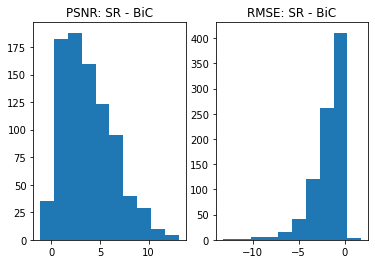

In [54]:
# Sanity check, plot a histogram of how well the SR image performed compared to the Bicubic comparison
fig, axs = plt.subplots(1, 2)
axs[0].hist([float(x) for x in comp['psnr']], bins=10)
axs[0].set_title('PSNR: SR - BiC')
axs[1].hist([float(x) for x in comp['rmse']], bins=10)
axs[1].set_title('RMSE: SR - BiC')

# Final Application

Okay, now lets try things on whole `.nii` images, instead of patches! We do the same as before, but this time don't take any patches, just the whole image. You should be able to put just about any `.nii` image into the input folder and the model will work.

In [55]:
# Generate testing data for both axes
sr = SrGen('../data/CNNIL_nifti/Raw_test/','../data/CNNIL_nifti/Full_test/','../data/CNNIL_nifti/LR_Full_test/')

temp = sr.get_template()
temp['out_type'] = 'nii'
temp['resolution'] = [2,2,2]
temp['translation'] = [0, 0, 0]
temp['rotation'] = [0, 0, 0]
temp['keep_blank'] = False
temp['same_size'] = False

sr.set_template(temp)

#sr.run(clear=True, save=True)
sr.match_altered(update=True, paths=False, sort=False)


params_t = {'batch_size': 1,
        'shuffle': False,
        'num_workers': 2}

full_img_generator = Dataset(sr, axs = 'hw')

HR and LR file locations updated


### Use the models for SR of MRI images and calculate PSNR

In [56]:
# Load trained models:
net_1.load_state_dict(torch.load('CNNIL_save_network1_39.p'))
net_2.load_state_dict(torch.load('CNNIL_save_network2_39.p'))

# Where or not to save the output SR images, if None then don't save any:
save_pre = './SR_images'


with torch.no_grad():
    comp={'psnr' : [], 'rmse' : []}
    for idx, [im_l, im_h] in enumerate(full_img_generator):

        output_1, output_2 = net_1(torch.transpose(im_l,0,1))
        output_1, output_2 = net_2(torch.transpose(output_2,0,3))
        output_2 = torch.transpose(torch.squeeze(output_2,1),2,0)

        # Upscale im_l to the same size as im_h
        im_l = torch.tensor(resize(im_l, im_h.shape, order=1, mode = 'symmetric'))

        # Calculate PSNR for bicubic
        diff = im_l - im_h
        rmse_b = np.sqrt((diff**2).mean())
        psnr_b = 20*np.log10(im_h.max()/rmse_b)


        # Calculate PSNR for SR
        diff = output_2 - im_h
        rmse_s = np.sqrt((diff**2).mean())
        psnr_s = 20*np.log10(im_h.max()/rmse_s)

        comp['psnr'].append(psnr_s-psnr_b)
        comp['rmse'].append(rmse_s-rmse_b)

        if save_pre:
            # Save the resulting images as .nii files
            os.makedirs(save_pre,exist_ok=True)
            sr.save_image(f'{save_pre}/{sr.LR_files[idx].split("/")[-1]}', output_2.numpy())


Text(0.5, 1.0, 'RMSE: SR - BiC')

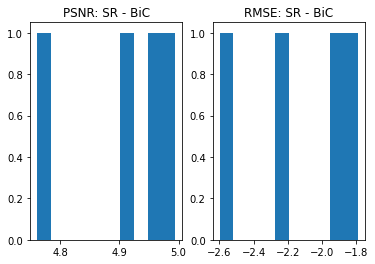

In [57]:
fig, axs = plt.subplots(1, 2)
axs[0].hist([float(x) for x in comp['psnr']], bins=10)
axs[0].set_title('PSNR: SR - BiC')
axs[1].hist([float(x) for x in comp['rmse']], bins=10)
axs[1].set_title('RMSE: SR - BiC')

### Compare Slices from SR and HR image

Text(0.5, 1.0, 'Truth')

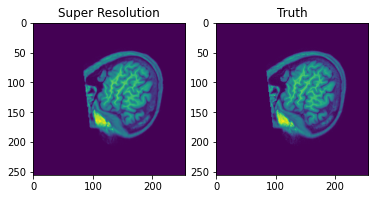

In [62]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(torch.squeeze(output_2[40,:,:],0))
axs[0].set_title('Super Resolution')
axs[1].imshow(sr.load_image(sr.HR_files[-1])[40,:,:])
axs[1].set_title('Truth')

## Conclusion

There we have it! A nice version of the pipeline discussed using Pytorch!

Potential directions for future development:
- Determine how well the model works with different MRI collection parameters
- Train it on other medical image types aside from MRI